### EDA

In [47]:
#from google.colab import files
#uploaded = files.upload()


In [49]:
import pandas as pd
import os

# Set the folder where your parquet files are stored
base_path = r"C:\Users\HP\Desktop\DeepLearningProject\EMOJIPREDICTION"

# Load datasets
train = pd.read_parquet(os.path.join(base_path, "train-00000-of-00001.parquet"))
val   = pd.read_parquet(os.path.join(base_path, "validation-00000-of-00001.parquet"))
test  = pd.read_parquet(os.path.join(base_path, "test-00000-of-00001 (1).parquet"))

# Print dataset shapes
print(train.shape, val.shape, test.shape)


(45000, 2) (5000, 2) (50000, 2)


In [11]:
#!ls -lh /content


In [ ]:
import pandas as pd

train = pd.read_parquet("train-00000-of-00001.parquet")
val   = pd.read_parquet("validation-00000-of-00001.parquet")
test  = pd.read_parquet("test-00000-of-00001 (1).parquet")

print(train.shape, val.shape, test.shape)

In [15]:
print(train.columns)
print(train.head())
print(len(train), len(val), len(test)) #Isn't 50 000 columns huge for testing ?train.iloc[1]

Index(['text', 'label'], dtype='object')
                                                text  label
0  Sunday afternoon walking through Venice in the...     12
1  Time for some BBQ and whiskey libations. Chomp...     19
2  Love love love all these people ️ ️ ️ #friends...      0
3                                ️ ️ ️ ️ @ Toys"R"Us      0
4  Man these are the funniest kids ever!! That fa...      2
45000 5000 50000


In [17]:
# Step 1: Define label: emoji mapping (from dataset card)
id2emoji = {
    0:"❤",  1:"😍",  2:"😂",  3:"💕",  4:"🔥",
    5:"😊",  6:"😎",  7:"✨",  8:"💙",  9:"😘",
   10:"📷", 11:"🇺🇸", 12:"☀", 13:"💜", 14:"😉",
   15:"💯", 16:"😁", 17:"🎄", 18:"📸", 19:"😜",
}
emoji2id = {e:i for i,e in id2emoji.items()}

In [19]:
# Step 2: Add emoji column for readability
train["emoji"] = train["label"].map(id2emoji)
val["emoji"]   = val["label"].map(id2emoji)
test["emoji"]  = test["label"].map(id2emoji)

print(train.head())

                                                text  label emoji
0  Sunday afternoon walking through Venice in the...     12     ☀
1  Time for some BBQ and whiskey libations. Chomp...     19     😜
2  Love love love all these people ️ ️ ️ #friends...      0     ❤
3                                ️ ️ ️ ️ @ Toys"R"Us      0     ❤
4  Man these are the funniest kids ever!! That fa...      2     😂


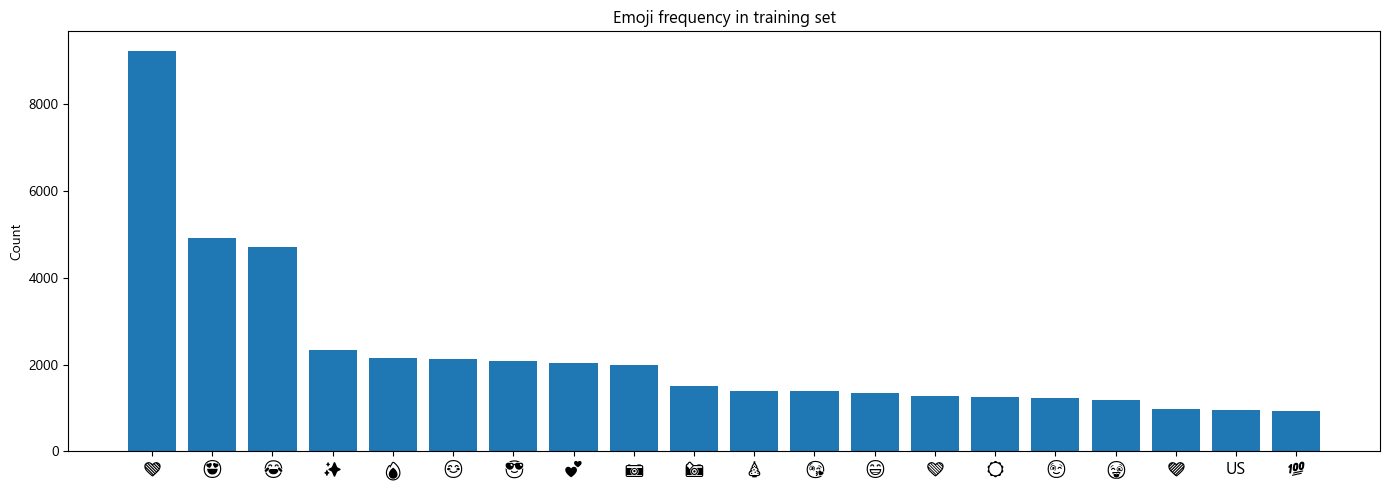

In [21]:
# 🔹 Step 3: Class distribution (train set)
import matplotlib.pyplot as plt
import unicodedata

# 1) Normalize: strip variation selectors (U+FE0F) so fonts have a better chance
def normalize_emoji(e: str) -> str:
    return e.replace("\ufe0f", "")  # remove VS16

# 2) Map very problematic ones to near-equivalents that render better
emoji_fix = {
    "❤️": "❤",   # heart with VS16 -> heavy black heart
    "☀️": "☀",   # sun with VS16   -> sun
    "🇺🇸": "US"   # flags are often broken; show text label instead
}

def safe_emoji(e: str) -> str:
    e = emoji_fix.get(e, e)
    return normalize_emoji(e)

# Build safe labels for plotting
counts = train["emoji"].map(safe_emoji).value_counts()

# 3) Ask matplotlib to use a font that usually includes emoji glyphs on Windows
plt.rcParams['font.family'] = 'Segoe UI Emoji'  # on Windows 10/11
plt.figure(figsize=(14,5))
bars = plt.bar(counts.index, counts.values)
plt.title("Emoji frequency in training set")
plt.ylabel("Count")
plt.xticks(rotation=0, fontsize=12)
plt.tight_layout()
plt.show() #Square issue and Bias.



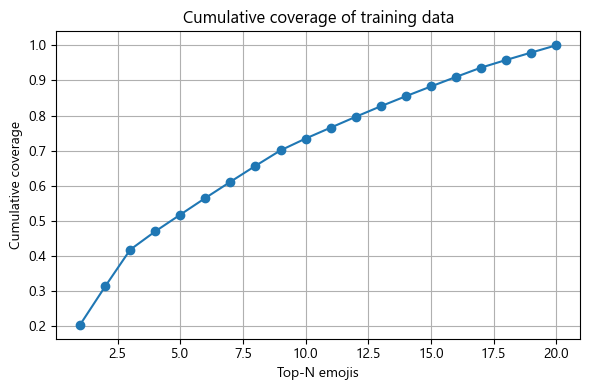

Top-3 classes cover 41.8% of training data
Top-5 classes cover 51.8% of training data
Top-10 classes cover 73.5% of training data


In [22]:
# 1) CUMULATIVE COVERAGE: how many emojis cover most of the data

import numpy as np
import matplotlib.pyplot as plt

# Get counts per emoji, sorted by frequency
counts = train["emoji"].value_counts()
sorted_counts = counts.values[np.argsort(-counts.values)]
# Cumulative sum / total → coverage ratio
cum = np.cumsum(sorted_counts) / sorted_counts.sum()

# Plot coverage curve
plt.figure(figsize=(6,4))
plt.plot(range(1, len(sorted_counts)+1), cum, marker="o")
plt.xlabel("Top-N emojis")
plt.ylabel("Cumulative coverage")
plt.title("Cumulative coverage of training data")
plt.grid(True)
plt.tight_layout()
plt.show()

# Quick numbers for the report (coverage at top-k)
for k in [3,5,10]:
    print(f"Top-{k} classes cover {cum[k-1]*100:.1f}% of training data")

/tmp/ipython-input-3387156094.py:21: UserWarning: Glyph 10024 (\N{SPARKLES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3387156094.py:21: UserWarning: Glyph 127482 (\N{REGIONAL INDICATOR SYMBOL LETTER U}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3387156094.py:21: UserWarning: Glyph 127480 (\N{REGIONAL INDICATOR SYMBOL LETTER S}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3387156094.py:21: UserWarning: Glyph 127876 (\N{CHRISTMAS TREE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3387156094.py:21: UserWarning: Glyph 128149 (\N{TWO HEARTS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3387156094.py:21: UserWarning: Glyph 128153 (\N{BLUE HEART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipython-input-3387156094.py:21: UserWarning: Glyph 128156 (\N{PURPLE HEART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp

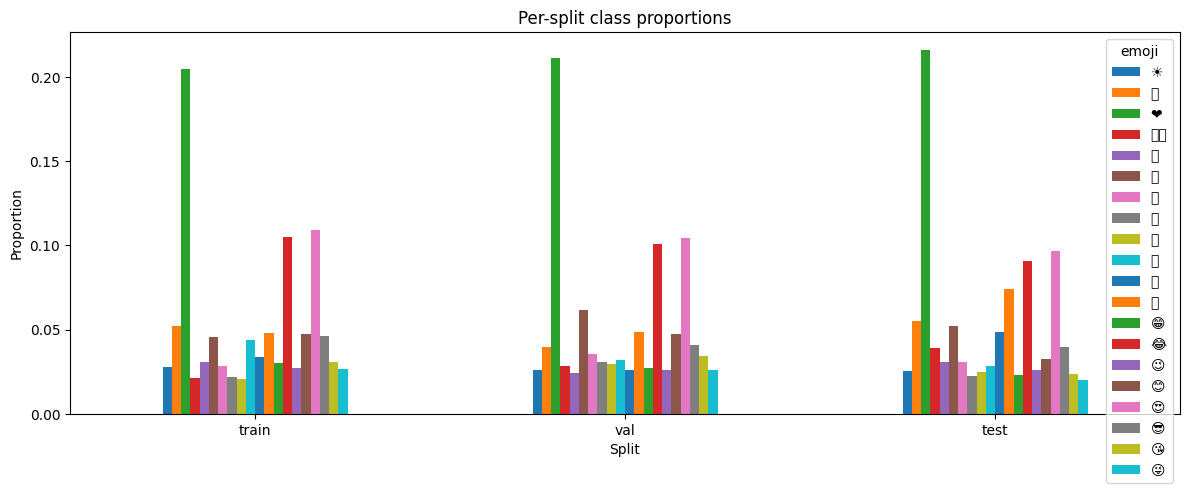

Saved class_proportions_by_split.csv


In [10]:
# 2) CLASS DISTRIBUTION ACROSS SPLITS (train, val, test)
import pandas as pd

# Helper: get proportions instead of raw counts
def prop(df):
    c = df["emoji"].value_counts().sort_index()
    return (c / c.sum()).rename(df.name)

# Add "names" to splits
train.name, val.name, test.name = "train", "val", "test"

# Concatenate proportions into one table
props = pd.concat([prop(train), prop(val), prop(test)], axis=1).fillna(0)

# Plot comparison (bars = each split, grouped by emoji)
ax = props.T.plot(kind="bar", figsize=(12,5))
ax.set_title("Per-split class proportions")
ax.set_xlabel("Split")
ax.set_ylabel("Proportion")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Save tidy CSV for the report
props.to_csv("class_proportions_by_split.csv")
print("Saved class_proportions_by_split.csv")

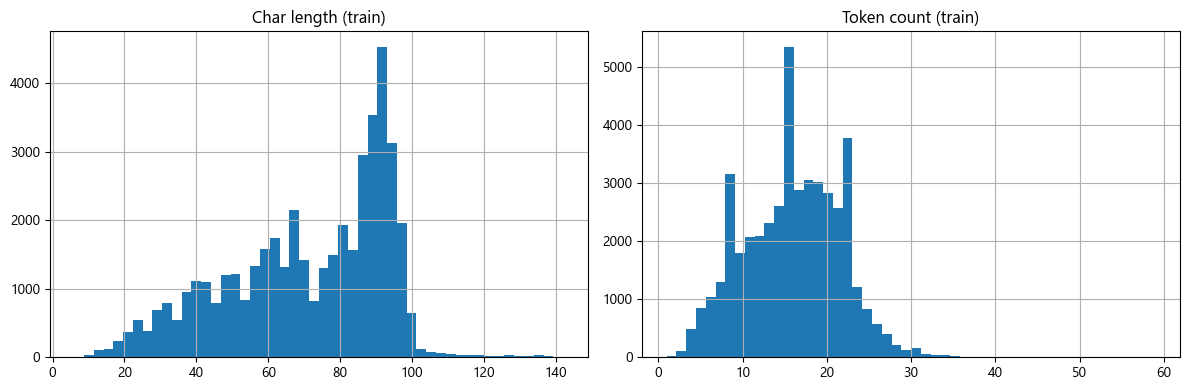

            n_chars      n_tokens
count  45000.000000  45000.000000
mean      71.016911     15.935156
std       22.248420      5.738466
min        6.000000      1.000000
25%       55.000000     12.000000
50%       76.000000     16.000000
75%       90.000000     20.000000
max      142.000000     59.000000


In [25]:
# 3) TEXT LENGTH DISTRIBUTION (chars & tokens)
# Useful for deciding max_seq_length during training
import re

# Simple tokenizer: split words & punctuation
#This is a very lightweight tokenizer — just enough for EDA, not for actual model training
#(we’ll use Hugging Face tokenizers later).
def basic_tokens(s):
    return re.findall(r"\w+|[^\w\s]", str(s), re.UNICODE)

# Add columns: number of characters, number of tokens
train["n_chars"] = train["text"].str.len()
train["n_tokens"] = train["text"].apply(lambda s: len(basic_tokens(s)))

# Plot histograms
fig = plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
train["n_chars"].hist(bins=50)
plt.title("Char length (train)")
plt.subplot(1,2,2)
train["n_tokens"].hist(bins=50)
plt.title("Token count (train)")
plt.tight_layout()
plt.show() #Spikes...

# Summary stats (median, mean, percentiles)
print(train[["n_chars","n_tokens"]].describe())

In [29]:
# 4) IMBALANCE METRICS + SUGGESTED CLASS WEIGHTS
# (to handle imbalance during training)
counts = train["emoji"].value_counts().sort_index()
p = counts.values / counts.values.sum()

# Gini index: 0=perfect balance, closer to 1=skewed
gini = 1.0 - np.sum(p**2)
# Entropy: higher = more uniform distribution
entropy = -np.sum(p * np.log2(p + 1e-12))
# Ratio of most frequent to least frequent class
max_min = counts.max() / counts.min()

print(f"Gini: {gini:.4f}  |  Entropy: {entropy:.2f} (max {np.log2(len(counts)):.2f})  |  Max/Min: {max_min:.1f}x")

# Compute class weights = inverse frequency (normalized)
inv = 1.0 / np.maximum(counts.values.astype(float), 1.0)
class_weights = inv * (len(inv) / inv.mean())

# Save as CSV for training
weights_df = pd.DataFrame({
    "label_id": range(len(counts)),
    "emoji": counts.index,
    "count_train": counts.values,
    "class_weight": class_weights
})
weights_df.to_csv("class_weights_suggested.csv", index=False)
print("Saved class_weights_suggested.csv")

Gini: 0.9137  |  Entropy: 3.95 (max 4.32)  |  Max/Min: 9.9x
Saved class_weights_suggested.csv


In [31]:
# 5) SAMPLES PER CLASS (for qualitative analysis in report)
# Get up to 3 random tweets per emoji
samples_per_class = (
    train.groupby("emoji")
         .apply(lambda g: g.sample(min(3, len(g)), random_state=42)[["text","label"]])
         .reset_index(level=0)
         .rename(columns={"level_0":"emoji"})
)
samples_per_class.to_csv("samples_per_emoji_train.csv", index=False)
print("Saved samples_per_emoji_train.csv")


Saved samples_per_emoji_train.csv


In [33]:
# 6) SANITY CHECKS (empties, duplicates)
# Count empty text rows
print("Empty texts in train:", (train["text"].str.strip()=="").sum())

# Count duplicates (same text + same label)
dup_rows = train.duplicated(subset=["text","label"]).sum()
print("Duplicate (text,label) rows in train:", dup_rows)

Empty texts in train: 0
Duplicate (text,label) rows in train: 337


With these blocks we’ll have:

1) Coverage curve : shows dominance of top emojis.
2) Per-split comparison : shows splits are balanced.
3) Text length stats : guides tokenizer settings.
4) Imbalance metrics + class weights : for model training.
5) Sample tweets per class : great for our appendix.
6) Sanity checks : good practice for reproducibility.


### PreProcessing

In [37]:
# Libraries and set-up
import os, re, numpy as np, pandas as pd, torch, json
from sklearn.metrics import accuracy_score, f1_score
from transformers import (AutoTokenizer, AutoModelForSequenceClassification,
                          TrainingArguments, Trainer, TrainerCallback)
from datasets import Dataset
import types



device = torch.device("cuda" if torch.cuda.is_available() else "cpu") #Check GPU avalailability.
SEED = 42 #Choose random seed.
torch.manual_seed(SEED) #Set pytorch's seed.
np.random.seed(SEED) # Set numpy's seed.

# Check number of emojis we want to predict. (Should be 20).
NUM_LABELS = len(id2emoji)
print(NUM_LABELS) #ok.
print(train.head()) #Have a look at training set head for reference of columns.

ModuleNotFoundError: No module named 'torch'

In [16]:
# PREPROCESSING 1 : Remove duplicates
# We counted 337 duplicate rows in traning.
# Let's Drop exact duplicates (same text + same label) in each split
for name, df in [("train", train), ("val", val), ("test", test if "test" in globals() else None)]:
    if df is None:
        continue
    before = len(df)
    df.drop_duplicates(subset=["text", "label"], inplace=True)
    df.reset_index(drop=True, inplace=True)
    print(f"{name}: removed {before - len(df)} exact (text,label) duplicates")

train: removed 337 exact (text,label) duplicates
val: removed 0 exact (text,label) duplicates
test: removed 0 exact (text,label) duplicates


In [17]:
# PREPROCESSING 2 : Remove/mask any label emojis from the text to avoid leakage.

#Define a function to remove emojis, urls etc...
def clean_text(s: str) -> str:
    # Takes a string s as input and outputs a string. Uses regex to find specific unicode emojis and replaces them with a [EMOJI] token.
    # Removes urls to put blanck spaces instead and
    s = re.sub(pattern, "[EMOJI]", s)         # mask label emojis only with a toekn [EMOJI]
    s = re.sub(r"https?://\S+|www\.\S+", " ", s)   # remove urls and replace them with a 'space'. We could use a [URL] token but it might be misleading.
    s = re.sub(r"@\w+", "@user", s)                # replaces user mentions by just @user.
    return s.strip()


label_emojis = "|".join(map(re.escape, id2emoji.values())) # all emjois linked with an OR : |, statement to match any of our emojis.
emoji_vs = "\ufe0f"  # variation selector to also catch the emojis defined with the unicode.
pattern = re.compile(f"(?:{label_emojis}){emoji_vs}?") #any of our 20 emojis, with or without the variation selector.

#Apply the function on all our three datasets.
for df in train, val, test :
    df["text"] = df["text"].astype(str).apply(clean_text)


In [18]:
df.iloc[1]

,1
text,The calm before...... | w/ sofarsounds @user |...
label,10
emoji,📷


# Model 1 - BERTweet

In [53]:
# CHOOSE MODEL

# Our task is to predict a specific label based on a text context which is a tweet written in english.
# We know BERT and, furthertmore, RoBERTa (not XLM as there's only english tweets) are good choices.
# Leening deeper into the available models, we found BERTweet (based on RoBERTa's architecture, so more robust than the regular BERT) which is pre-trained specifically on hundred millions of tweets.
# Since tweet's structure are quite different from wikipedia, scientific articles etc... (because of slang, short sentences etc...) using BERTtweet might be more efficient to capture the meaning of a sentence and predict the corresponding emoji.
# As a first step, we will use this model.
# The model's article's DOI is : https://doi.org/10.18653/v1/2020.emnlp-demos.2



pre_trained_model_bertweet = "vinai/bertweet-base"
tokenizer_bertweet = AutoTokenizer.from_pretrained(pre_trained_model_bertweet, use_fast=True, normalization=True)
#normalization = True makes sure to apply HF preprocessing procedure to our tweets, so its coherent with what BERTweet did.
#use_fast = True to run the optimized tokenizer backend (and go quicker).

# Convert pandas data frames to datasets to work easily with HF's pipeline (.map(), .predict() etc..)
ds_train = Dataset.from_pandas(train[["text","label"]].rename(columns={"label":"labels"}))
ds_val  = Dataset.from_pandas(val[["text","label"]].rename(columns={"label":"labels"}))
ds_test = Dataset.from_pandas(test[["text","label"]].rename(columns={"label":"labels"}))

NameError: name 'AutoTokenizer' is not defined

In [20]:
# During the EDA, with a simple tokenize we had a low number of max tokens in a text. Let's check if that is till the case with our tokenizer :
def count_tokens_bertweet(texts):
    return [len(tokenizer_bertweet.encode(t, add_special_tokens=True)) for t in texts]

train_lengths_bertweet = count_tokens_bertweet(train["text"].tolist())

# basic stats
series_bertweet = pd.Series(train_lengths_bertweet)
print(series_bertweet.describe(percentiles=[.5, .9, .95, .99]))
print(f"Max tokens: {series_bertweet.max()}")

# See % of tweets exceeding common cutoffs
for cutoff in [32, 64, 128]:
    pct = (series_bertweet > cutoff).mean()*100
    print(f"> {cutoff} tokens: {pct:.2f}%")

count    44663.00000
mean        19.25220
std          6.06154
min          4.00000
50%         20.00000
90%         27.00000
95%         28.00000
99%         31.38000
max         63.00000
dtype: float64
Max tokens: 63
> 32 tokens: 0.61%
> 64 tokens: 0.00%
> 128 tokens: 0.00%


In [21]:
#Tokenize and Format
# From previous step :
MAX_LEN = 64   # adjust from your length EDA (e.g., 95th percentile)

# Define a function to tokenize our datasets text column using the imported tokenizer.
#We safely use truncation = True, even though our max_len is bigger than the biggest tokenized tweet.
def tokenize_batch_bertweet(examples):
    return tokenizer_bertweet(examples["text"], truncation=True, padding="max_length", max_length=MAX_LEN)


ds_train = ds_train.map(tokenize_batch_bertweet, batched=True, remove_columns=["text"]) #.map automatically passes a batch to tokenize_batch, note tha since MAX_LEN is defined globally, the function can see it.
ds_val  = ds_val.map(tokenize_batch_bertweet, batched=True, remove_columns=["text"])
ds_test = ds_test.map(tokenize_batch_bertweet, batched=True, remove_columns=["text"])
#The tokenizer adds input_ids and attenion_mask.
# input_ids are the ids of the tokens representing each sequence.
# Attention_mask tells for each token position if its a real token or padding.

# set format for PyTorch (tensor objects)
cols = ["input_ids","attention_mask","labels"]
ds_train.set_format(type="torch", columns=cols)
ds_val.set_format(type="torch", columns=cols)
if test is not None: ds_test.set_format(type="torch", columns=cols)

Map:   0%|          | 0/44663 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [22]:
# Define the model
model_bertweet = AutoModelForSequenceClassification.from_pretrained(pre_trained_model_bertweet, num_labels=NUM_LABELS, problem_type="single_label_classification").to(device)
# We choose here a single_label_classification problem to attach only one emoji to each tweet.
# We could ultimately extend this.

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/bertweet-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

In [23]:
# Handle imbalance in the dataset.
# If we train wihtout correction, the model can "cheat" by predicting only the most present emojis and still get high accuracy.
# Lets create a class_weights to tell the loss function how much each class should matter based on its represnetation in the dataset.
# We'll hence use a custom compute loss function for that, define below.

weights_csv = "class_weights_suggested.csv"
#If it exists already (most likley if ran the whole jupyter notebook) If not create it like before.
if os.path.exists(weights_csv):
    w_bertweet = pd.read_csv(weights_csv).sort_values("label_id")["class_weight"].values
    class_weights = torch.tensor(w_bertweet, dtype=torch.float32, device=device)
else:
    counts_bertweet = train["label"].value_counts().sort_index().values.astype(float)
    inv = 1.0 / np.maximum(counts_bertweet, 1.0)
    class_weights = torch.tensor(inv * (len(inv)/inv.mean()), dtype=torch.float32, device=device)


# Custom loss function with class weights (to handle imbalance)
def custom_compute_loss_bertweet(self, model, inputs, return_outputs=False, **kwargs):
    labels = inputs.pop("labels") # Extract the true labels from the batch
    outputs = model(**inputs)  # Unpack the dictionnary
    logits = outputs.logits # Get the predicted logits from the unpcked dictionnary (unnormalized scores of the labels)
    loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights.to(logits.device)) #compute weighted cross-entropy loss using the imbalance correction.
    loss = loss_fct(logits, labels.to(logits.device)) # Compute the loss comparing predictions vs labels
    return (loss, outputs) if return_outputs else loss  # Return (loss, outputs) if Trainer needs both; otherwise just loss



# Metrics for evaluation (accuracy, macro-F1, top-3 accuracy)
def compute_metrics_bertweet(eval_pred):
    logits, labels = eval_pred # Unpack predictions (logits) and ground-truth labels
    preds = logits.argmax(-1)  # Predicted class = index of max logit for each example
    acc = accuracy_score(labels, preds) # compute the accuracy(% of exact matches)
    f1m = f1_score(labels, preds, average="macro") # Macro-F1 = average F1 across classes (treats all emojis equally, important for imbalance)

    # Top-3 accuracy:
    # Check if the true label is within the top-3 highest predicted logits for each example
    top3_acc = (
        (labels.reshape(-1, 1) == np.argsort(-logits, axis=1)[:, :3])  # Compare true label vs top-3 predictions
        .any(axis=1) # True if at least one match
        .mean() # Average across all samples
    )

    return {"accuracy": acc, "f1_macro": f1m, "top3_acc": top3_acc}


In [24]:
#Prepare parameters for training
args_bertweet = TrainingArguments(
    output_dir="runs/emoji_BERTweet",
    do_train=True,
    do_eval=True,
    learning_rate=2e-5, #Good trade-off, says the internet.
    per_device_train_batch_size=16, #Should be ok for everyone, otherwise we go back to the default 8 or lower.
    per_device_eval_batch_size=16,
    num_train_epochs=3, #The Dataset isnt' that huge, we don't want to overfit...
    weight_decay=0.01, #helps reduce overfitting and is the default reccomended by HF.
    logging_dir="runs/emoji_BERTweet/logs",
    logging_steps=50,  # log every 50 steps
    eval_steps=1000,  #run validation every 1000 steps
    save_steps=1000, #save a checkpoint every 1000 steps
    seed=SEED,
)

trainer_bertweet = Trainer(
    model=model_bertweet,
    args=args_bertweet,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    processing_class=tokenizer_bertweet,         # ok on your version; replaces tokenizer=
    compute_metrics=compute_metrics_bertweet,    # your metrics (acc, macro-F1, top-3)
)

# Use your weighted loss during training
trainer_bertweet.compute_loss = types.MethodType(custom_compute_loss_bertweet, trainer_bertweet)



In [25]:
# Traning and save the best-on-eval model using the logs.

# Define a function that builds a subclass of Hugging Face's TrainerCallback.
# This callback is triggered every time the Trainer runs evaluation (at eval_steps or at the end of an epoch).
# On each evaluation, it checks the chosen metric (e.g. f1_macro).
# If the metric improves compared to previous runs, it saves the current model/tokenizer to `path`
# and writes a small JSON file with the step/epoch/metric value.
def make_savebest_callback_bertweet(trainer_bertweet,
                           metric_candidates=("eval_f1_macro", "f1_macro", "eval_accuracy", "accuracy"),
                           mode="max",
                           path="runs/emoji_BERTweet/best"):
    class SaveBestCallback(TrainerCallback):
        def __init__(self):
            self.best = None
            self.key  = None
            os.makedirs(path, exist_ok=True)

        def on_evaluate(self, args, state, control, metrics, **kwargs):
            key = next((m for m in metric_candidates if m in metrics), None)
            if key is None:
                return
            val = float(metrics[key])

            is_better = (self.best is None) or ((mode == "max" and val > self.best) or (mode == "min" and val < self.best))
            if is_better:
                self.best, self.key = val, key
                trainer_bertweet.save_model(path)
                try:
                    (trainer_bertweet.processing_class or trainer_bertweet.tokenizer).save_pretrained(path)
                except Exception:
                    pass
                meta = {
                    "metric_name": key,
                    "metric_value": val,
                    "global_step": int(state.global_step),
                    "epoch": float(state.epoch) if state.epoch is not None else None,
                }
                with open(os.path.join(path, "best_meta.json"), "w") as f:
                    json.dump(meta, f, indent=2)
                if meta["epoch"] is not None:
                    epoch_str = f"{meta['epoch']:.2f}"
                else:
                    epoch_str = "N/A"
                print(f"✓ New best {key}={val:.4f} at step {meta['global_step']}, epoch {epoch_str}. Saved to {path}")
    return SaveBestCallback()
#Applies the class change on the trainer.
trainer_bertweet.add_callback(make_savebest_callback_bertweet(
    trainer_bertweet,
    metric_candidates=("eval_f1_macro","f1_macro"),
    mode="max",
    path="runs/emoji_BERTweet/best"
))

#Train (checkpoints every save_steps; best snapshot maintained by the callback) — Takes ~25min.
trainer_bertweet.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: christineismail19 (christineismail19-data-sciencetech-institute) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
50,2.765400
100,2.603700
150,2.454700
200,2.254500
250,2.219700
300,2.126100
350,2.148400
400,2.150700
450,2.072600
500,1.978800


TrainOutput(global_step=8376, training_loss=1.5852880231972069, metrics={'train_runtime': 1726.9878, 'train_samples_per_second': 77.585, 'train_steps_per_second': 4.85, 'total_flos': 4407460595062272.0, 'train_loss': 1.5852880231972069, 'epoch': 3.0})

In [26]:
#Evaluate and save the final model from the last step on the validation set (not necessarily the best model)
final_val_bertweet = trainer_bertweet.evaluate()
print("\nFinal (last-step) VAL metrics BERTweet:", final_val_bertweet)
trainer_bertweet.save_model("runs/emoji_BERTweet/final")

best_dir_bertweet = "runs/emoji_BERTweet/best"
best_meta_path_bertweet = os.path.join(best_dir_bertweet, "best_meta.json")
if os.path.exists(best_meta_path_bertweet) and os.path.getsize(best_meta_path_bertweet) > 0:
    with open(best_meta_path_bertweet, "r") as f:
        best_meta_bertweet = json.load(f)
    print("\nBest checkpoint:")
    print(f"- Metric: {best_meta_bertweet['metric_name']} = {best_meta_bertweet['metric_value']:.4f}")
    print(f"- From step: {best_meta_bertweet['global_step']}")
    print(f"- Approx. epoch: {best_meta_bertweet['epoch']}")
else:
    print("\nNo valid best_meta.json found (maybe no eval improvement yet).")

# evaluate the best model on VAL set again, just to print a clean summary
best_model_bertweet = AutoModelForSequenceClassification.from_pretrained(best_dir_bertweet).to(device)
best_trainer_bertweet = Trainer(
    model=best_model_bertweet,
    args=args_bertweet,
    eval_dataset=ds_val,
    processing_class=tokenizer_bertweet,
    compute_metrics=compute_metrics_bertweet
)
best_val_bertweet = best_trainer_bertweet.evaluate()
print("BEST VAL metrics BERTweet:", best_val_bertweet)



#Metrics from final VAL metrics :reparation_time': 0.0009, 'eval_accuracy': 0.3004, 'eval_f1_macro': 0.26949233343733797,
# 'eval_top3_acc': 0.5454, 'eval_runtime': 28.8152, 'eval_samples_per_second': 173.52,
# 'eval_steps_per_second': 10.862}
## Note tha both have the same eval_top3_acc so they probably predicted the same thing.
#{'eval_loss': 2.273836851119995, 'eval_accuracy': 0.3004, 'eval_f1_macro': 0.26949233343733797,
#'eval_top3_acc': 0.5454, 'eval_runtime': 28.5858, 'eval_samples_per_second': 174.912,
#'eval_steps_per_second': 10.949, 'epoch': 3.0}
#Metrics from best VAL :

#{'eval_loss': 2.3447043895721436, 'eval_model_p

✓ New best eval_f1_macro=0.2684 at step 8376, epoch 3.00. Saved to runs/emoji_BERTweet/best

Final (last-step) VAL metrics BERTweet: {'eval_loss': 2.2955000400543213, 'eval_accuracy': 0.296, 'eval_f1_macro': 0.2683655571830725, 'eval_top3_acc': 0.542, 'eval_runtime': 15.7528, 'eval_samples_per_second': 317.403, 'eval_steps_per_second': 19.869, 'epoch': 3.0}

Best checkpoint:
- Metric: eval_f1_macro = 0.2684
- From step: 8376
- Approx. epoch: 3.0


BEST VAL metrics BERTweet: {'eval_loss': 2.3591647148132324, 'eval_model_preparation_time': 0.0028, 'eval_accuracy': 0.296, 'eval_f1_macro': 0.2683655571830725, 'eval_top3_acc': 0.542, 'eval_runtime': 15.9059, 'eval_samples_per_second': 314.349, 'eval_steps_per_second': 19.678}


In [27]:
#Test the best model found on some sentence.

#best_model = AutoModelForSequenceClassification.from_pretrained("runs/emoji_BERTweet/best").to(device)
#best_model.eval()

# Define a function to predict the top-3
#def predict_topk(texts, k=3):
    #with torch.inference_mode():
        #toks = tokenizer(
            #texts, return_tensors="pt", padding=True,
            #truncation=True, max_length=MAX_LEN
        #)
        # move ALL tensors to the same device explicitly
        #toks = {k: v.to(device) for k, v in toks.items()}

        #logits = best_model(**toks).logits
        #probs = torch.softmax(logits, dim=-1).cpu().numpy()
        #topk_ids = np.argsort(-probs, axis=1)[:, :k]
        ##topk_emojis = [[id2emoji[i] for i in row] for row in topk_ids]
        #return topk_emojis, probs

#print(predict_topk(["My cat is sick, I'm so sad"])[0])  #I want to dance #My cat is sick, I'm so sad : Issue #That's funny
#print(predict_topk(["My cat just fell off the bed, I'm dead"])[0])
#print(predict_topk(["Watching news feels like pure comedy nowadays"])[0])
#Issue : nothing negative in the data .... Nothing negative for the labels.


Starting point for comparison :...
#We can start from an existing model !
#I found this : https://huggingface.co/cardiffnlp/twitter-roberta-base-emoji-latest

In [35]:
#Test of : https://huggingface.co/cardiffnlp/twitter-roberta-base-emoji-latest
from transformers import pipeline
#text = " My cat is sick, I'm so sad "
#text = " My cat just fell off the bed, I'm dead" #" Trump advising to drink bleac: that's promising"
text = " Watching news feels like pure comedy nowadays"

pipe = pipeline('text-classification', model="cardiffnlp/twitter-roberta-base-emoji-latest", return_all_scores=True)
predictions = pipe(text)[0]
predictions = sorted(predictions, key=lambda d: d['score'], reverse=True)
predictions[:3]


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/351 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

Device set to use cuda:0
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


[{'label': '💀', 'score': 0.10063784569501877},
 {'label': '😆', 'score': 0.08476856350898743},
 {'label': '😹', 'score': 0.07674342393875122}]

In [36]:
# Evaluate BEST on TEST, if you have ds_test
#test_trainer = Trainer(model=best_model, args=args, eval_dataset=ds_test, processing_class=tokenizer, compute_metrics=compute_metrics)
#test_metrics = test_trainer.evaluate()
#print("TEST metrics (BEST model):", test_metrics)
#
#{'eval_loss': 1.7685818672180176, 'eval_model_preparation_time': 0.0008, 'eval_accuracy': 0.46934, 'eval_f1_macro': 0.3421333294445419,
#'eval_top3_acc': 0.67704, 'eval_runtime': 286.0157, 'eval_samples_per_second': 174.816, 'eval_steps_per_second': 10.926}
#
# test Twitter-RoBERTa, distillBert, RoBERTa...


## GRADING

# Model 2 - DistilBERT

In [37]:
pre_trained_model_distilbert = "distilbert-base-uncased"
tokenizer_distilbert = AutoTokenizer.from_pretrained(pre_trained_model_distilbert, use_fast=True)
# (No need for normalization=True; that's only for BERTweet)

# Convert pandas dataframes to HuggingFace Datasets for pipeline compatibility
ds_train = Dataset.from_pandas(train[["text", "label"]].rename(columns={"label": "labels"}))
ds_val   = Dataset.from_pandas(val[["text", "label"]].rename(columns={"label": "labels"}))
ds_test  = Dataset.from_pandas(test[["text", "label"]].rename(columns={"label": "labels"}))


In [38]:
# Check max tokens per tweet with DistilBERT tokenizer (eda used simple tokenizer)

def count_tokens_distilbert(texts):
    # For each text, count number of tokens after DistilBERT tokenization
    return [len(tokenizer_distilbert.encode(t, add_special_tokens=True)) for t in texts]

# List of tweet texts (as strings)
train_lengths_distilbert = count_tokens_distilbert(train["text"].tolist())

# Statistics for tokenized tweet lengths
series_distilbert = pd.Series(train_lengths_distilbert)
print(series_distilbert.describe(percentiles=[.5, .9, .95, .99]))
print(f"Max tokens: {series_distilbert.max()}")

# Check what % of tweets would be truncated at common sequence lengths
for cutoff in [32, 64, 128]:
    pct = (series_distilbert > cutoff).mean() * 100
    print(f"> {cutoff} tokens (DistilBERT): {pct:.2f}%")


count    44663.000000
mean        21.240624
std          7.328162
min          4.000000
50%         22.000000
90%         30.000000
95%         33.000000
99%         37.000000
max         75.000000
dtype: float64
Max tokens: 75
> 32 tokens (DistilBERT): 5.04%
> 64 tokens (DistilBERT): 0.00%
> 128 tokens (DistilBERT): 0.00%


In [39]:
# Tokenize and format datasets for DistilBERT (emoji classification)

MAX_LEN = 75  # Set maximum sequence length

# This function takes a batch of examples and applies the DistilBERT tokenizer:
# truncation=True: ensures that sequences longer than MAX_LEN are cut off
# padding="max_length": ensures all sequences are padded to MAX_LEN
# max_length=MAX_LEN: sets the maximum sequence length for

def tokenize_batch_distilbert(examples):
    return tokenizer_distilbert(
        examples["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LEN
    )

# Apply the tokenizer to each dataset split in batches for efficiency
# remove_columns=["text"] removes the original raw text after tokenization
ds_train = ds_train.map(tokenize_batch_distilbert, batched=True, remove_columns=["text"])
ds_val   = ds_val.map(tokenize_batch_distilbert, batched=True, remove_columns=["text"])
ds_test  = ds_test.map(tokenize_batch_distilbert, batched=True, remove_columns=["text"])

# After tokenization, each dataset now contains:
#input-ids: token IDs representing each token in the sequence
# attention_mask: 1 for real tokens, 0 for padding tokens

# Set format for PyTorch tensors so the datasets can be fed directly to HuggingFace Trainer
cols = ["input_ids", "attention_mask", "labels"]
ds_train.set_format(type="torch", columns=cols)
ds_val.set_format(type="torch", columns=cols)
if test is not None:
    ds_test.set_format(type="torch", columns=cols)

Map:   0%|          | 0/44663 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [40]:
from transformers import AutoModelForSequenceClassification

# Load pretrained DistilBERT for emoji classification
model_distilbert = AutoModelForSequenceClassification.from_pretrained(
    pre_trained_model_distilbert,                 # "distilbert-base-uncased"
    num_labels=NUM_LABELS,             # Number of emoji classes
    problem_type="single_label_classification"  # One emoji per tweet
).to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [41]:
# Handle class imbalance and define evaluation metrics (DistilBERT)

weights_csv = "class_weights_suggested.csv"

# Load precomputed class weights or compute from training set
if os.path.exists(weights_csv):
    w = pd.read_csv(weights_csv).sort_values("label_id")["class_weight"].values
    class_weights = torch.tensor(w, dtype=torch.float32, device=device)
else:
    counts = train["label"].value_counts().sort_index().values.astype(float)
    inv = 1.0 / np.maximum(counts, 1.0)
    class_weights = torch.tensor(inv * (len(inv)/inv.mean()), dtype=torch.float32, device=device)


# Custom weighted loss function for Trainer
def custom_compute_loss_distilbert(self, model, inputs, return_outputs=False, **kwargs):
    labels = inputs.pop("labels")  # Extract true labels
    outputs = model(**inputs)      # Forward pass
    logits = outputs.logits        # Raw predictions
    # Weighted cross-entropy handles class imbalance
    loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights.to(logits.device))
    loss = loss_fct(logits, labels.to(logits.device))
    return (loss, outputs) if return_outputs else loss


# Metrics for evaluation
def compute_metrics_distilbert(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)  # Predicted class = argmax over logits

    # Accuracy: proportion of exact matches
    acc = accuracy_score(labels, preds)

    # Macro F1: average F1 across all classes, important for imbalanced emojis
    f1m = f1_score(labels, preds, average="macro")

    # Top-3 accuracy: True if the correct emoji is in the top 3 predicted logits
    top3_acc = (
        (labels.reshape(-1, 1) == np.argsort(-logits, axis=1)[:, :3])  # Check top-3 predictions
        .any(axis=1)  # True if at least one match
        .mean()       # Average over all samples
    )

    return {"accuracy": acc, "f1_macro": f1m, "top3_acc": top3_acc}




In [42]:
# Prepare training arguments and Trainer for DistilBERT

from transformers import TrainingArguments, Trainer
import types

args_distilbert = TrainingArguments(
    output_dir="runs/emoji_DistilBERT",        # Updated output directory
    do_train=True,
    do_eval=True,
    learning_rate=1.5e-5,                      # Slightly lower than BERTweet to prevent overshooting
    per_device_train_batch_size=16,             # Reduced batch size to fit GPU/CPU memory
    per_device_eval_batch_size=16,
    num_train_epochs=3,                        # Keep 3 epochs; monitor validation for overfitting
    weight_decay=0.01,                         # Regularization
    logging_dir="runs/emoji_DistilBERT/logs",
    logging_steps=50,
    eval_steps=1000,
    save_steps=1000,
    seed=SEED,
)

trainer_distilbert = Trainer(
    model=model_distilbert,
    args=args_distilbert,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    tokenizer=tokenizer_distilbert,                       # Use DistilBERT tokenizer
    compute_metrics=compute_metrics_distilbert,           # Metrics: accuracy, macro-F1, top-3 accuracy
)

# Attach custom weighted loss to handle class imbalance
trainer_distilbert.compute_loss = types.MethodType(custom_compute_loss_distilbert, trainer_distilbert)


/tmp/ipython-input-1035205881.py:22: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_distilbert = Trainer(


In [43]:
# Traning and save the best-on-eval model using the logs.

# Define a function that builds a subclass of Hugging Face's TrainerCallback.
# This callback is triggered every time the Trainer runs evaluation (at eval_steps or at the end of an epoch).
# On each evaluation, it checks the chosen metric (e.g. f1_macro).
# If the metric improves compared to previous runs, it saves the current model/tokenizer to `path`
# and writes a small JSON file with the step/epoch/metric value.
def make_savebest_callback_distilbert(trainer_distilbert,
                           metric_candidates=("eval_f1_macro", "f1_macro", "eval_accuracy", "accuracy"),
                           mode="max",
                           path="runs/emoji_DistilBERT/best"):
    class SaveBestCallback(TrainerCallback):
        def __init__(self):
            self.best = None
            self.key  = None
            os.makedirs(path, exist_ok=True)

        def on_evaluate(self, args, state, control, metrics, **kwargs):
            key = next((m for m in metric_candidates if m in metrics), None)
            if key is None:
                return
            val = float(metrics[key])

            is_better = (self.best is None) or ((mode == "max" and val > self.best) or (mode == "min" and val < self.best))
            if is_better:
                self.best, self.key = val, key
                trainer_distilbert.save_model(path)
                try:
                    (trainer_distilbert.processing_class or trainer_distilbert.tokenizer).save_pretrained(path)
                except Exception:
                    pass
                meta = {
                    "metric_name": key,
                    "metric_value": val,
                    "global_step": int(state.global_step),
                    "epoch": float(state.epoch) if state.epoch is not None else None,
                }
                with open(os.path.join(path, "best_meta.json"), "w") as f:
                    json.dump(meta, f, indent=2)
                if meta["epoch"] is not None:
                    epoch_str = f"{meta['epoch']:.2f}"
                else:
                    epoch_str = "N/A"
                print(f"✓ New best {key}={val:.4f} at step {meta['global_step']}, epoch {epoch_str}. Saved to {path}")
    return SaveBestCallback()
#Applies the class change on the trainer.
trainer_distilbert.add_callback(make_savebest_callback_distilbert(
    trainer_distilbert,
    metric_candidates=("eval_f1_macro","f1_macro"),
    mode="max",
    path="runs/emoji_DistilBERT/best"
))

#Train (checkpoints every save_steps; best snapshot maintained by the callback) — Takes ~25min.
trainer_distilbert.train()


Step,Training Loss
50,2.809100
100,2.673600
150,2.690500
200,2.591100
250,2.569200
300,2.559300
350,2.575000
400,2.551800
450,2.505000
500,2.419900


TrainOutput(global_step=8376, training_loss=2.0711565022254512, metrics={'train_runtime': 961.6797, 'train_samples_per_second': 139.328, 'train_steps_per_second': 8.71, 'total_flos': 2600811305037000.0, 'train_loss': 2.0711565022254512, 'epoch': 3.0})

In [ ]:
#Evaluate and save the final model from the last step on the validation set (not necessarily the best model)
final_val_distilbert = trainer_distilbert.evaluate()
print("\nFinal (last-step) VAL metrics:", final_val_distilbert)
trainer_distilbert.save_model("runs/emoji_DistilBERT/final")

best_dir_distilbert = "runs/emoji_DistilBERT/best"
best_meta_path_distilbert = os.path.join(best_dir_distilbert, "best_meta.json")
if os.path.exists(best_meta_path_distilbert) and os.path.getsize(best_meta_path_distilbert) > 0:
    with open(best_meta_path_distilbert, "r") as f:
        best_meta_distilbert = json.load(f)
    print("\nBest checkpoint:")
    print(f"- Metric: {best_meta_distilbert['metric_name']} = {best_meta_distilbert['metric_value']:.4f}")
    print(f"- From step: {best_meta_distilbert['global_step']}")
    print(f"- Approx. epoch: {best_meta_distilbert['epoch']}")
else:
    print("\nNo valid best_meta.json found (maybe no eval improvement yet).")

#Evaluate the best model on VAL set again, just to print a clean summary
best_model_distilbert = AutoModelForSequenceClassification.from_pretrained(best_dir_distilbert).to(device)
best_trainer_distilbert = Trainer(
    model=best_model_distilbert,
    args=args_distilbert,
    eval_dataset=ds_val,
    processing_class=tokenizer_distilbert,
    compute_metrics=compute_metrics_distilbert
)
best_val_distilbert = best_trainer_distilbert.evaluate()
print("BEST VAL metrics:", best_val_distilbert)

#Final (last-step) VAL metrics: {'eval_loss': 2.1121139526367188,
#'eval_accuracy': 0.3204, 'eval_f1_macro': 0.2167555474606488,
#'eval_top3_acc': 0.5594, 'eval_runtime': 11.0031,
#'eval_samples_per_second': 454.419, 'eval_steps_per_second': 28.447, 'epoch': 3.0}

#Best checkpoint:
#Metric: eval_f1_macro = 0.2168@
# From step: 8376
# Approx. epoch: 3.0

#BEST VAL metrics: {'eval_loss': 2.3347840309143066,
#'eval_model_preparation_time': 0.0024, 'eval_accuracy': 0.3204,
#'eval_f1_macro': 0.2167555474606488, 'eval_top3_acc': 0.5594,
#'eval_runtime': 10.3396, 'eval_samples_per_second': 483.576,
#'eval_steps_per_second': 30.272}

✓ New best eval_f1_macro=0.2168 at step 8376, epoch 3.00. Saved to runs/emoji_DistilBERT/best

Final (last-step) VAL metrics: {'eval_loss': 2.1121139526367188, 'eval_accuracy': 0.3204, 'eval_f1_macro': 0.2167555474606488, 'eval_top3_acc': 0.5594, 'eval_runtime': 10.55, 'eval_samples_per_second': 473.934, 'eval_steps_per_second': 29.668, 'epoch': 3.0}

Best checkpoint:
- Metric: eval_f1_macro = 0.2168
- From step: 8376
- Approx. epoch: 3.0


BEST VAL metrics: {'eval_loss': 2.3347840309143066, 'eval_model_preparation_time': 0.0014, 'eval_accuracy': 0.3204, 'eval_f1_macro': 0.2167555474606488, 'eval_top3_acc': 0.5594, 'eval_runtime': 10.7997, 'eval_samples_per_second': 462.978, 'eval_steps_per_second': 28.982}


# Model 3 - DistilRoBERTa

In [ ]:
pre_trained_model_distilroberta = "distilbert/distilroberta-base"
tokenizer_distilroberta = AutoTokenizer.from_pretrained(pre_trained_model_distilroberta, use_fast=True)


# Convert pandas dataframes to HuggingFace Datasets for pipeline compatibility
ds_train = Dataset.from_pandas(train[["text", "label"]].rename(columns={"label": "labels"}))
ds_val   = Dataset.from_pandas(val[["text", "label"]].rename(columns={"label": "labels"}))
ds_test  = Dataset.from_pandas(test[["text", "label"]].rename(columns={"label": "labels"}))


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

In [ ]:
# During the EDA, with a simple tokenize we had a low number of max tokens in a text. Let's check if that is till the case with our tokenizer :
def count_tokens_distilroberta(texts):
    return [len(tokenizer_distilroberta.encode(t, add_special_tokens=True)) for t in texts]

train_lengths_distilroberta = count_tokens_distilroberta(train["text"].tolist())

# basic stats
series_distilroberta = pd.Series(train_lengths_distilroberta)
print(series_distilroberta.describe(percentiles=[.5, .9, .95, .99]))
print(f"Max tokens: {series_distilroberta.max()}")

# See % of tweets exceeding common cutoffs
for cutoff in [32, 64, 128]:
    pct = (series_distilroberta > cutoff).mean()*100
    print(f"> {cutoff} tokens: {pct:.2f}%")

count    44663.000000
mean        22.193919
std          7.559949
min          4.000000
50%         23.000000
90%         32.000000
95%         34.000000
99%         39.000000
max        131.000000
dtype: float64
Max tokens: 131
> 32 tokens: 7.82%
> 64 tokens: 0.02%
> 128 tokens: 0.00%


In [ ]:
#Tokenize and Format
# From previous step :
MAX_LEN = 131   # adjust from your length EDA (e.g., 95th percentile)

# Define a function to tokenize our datasets text column using the imported tokenizer.
#We safely use truncation = True, even though our max_len is bigger than the biggest tokenized tweet.
def tokenize_batch_distilroberta(examples):
    return tokenizer_distilroberta(examples["text"], truncation=True, padding="max_length", max_length=MAX_LEN)


ds_train = ds_train.map(tokenize_batch_distilroberta, batched=True, remove_columns=["text"]) #.map automatically passes a batch to tokenize_batch, note tha since MAX_LEN is defined globally, the function can see it.
ds_val   = ds_val.map(tokenize_batch_distilroberta, batched=True, remove_columns=["text"])
ds_test = ds_test.map(tokenize_batch_distilroberta, batched=True, remove_columns=["text"])
#The tokenizer adds input_ids and attenion_mask.
# input_ids are the ids of the tokens representing each sequence.
# Attention_mask tells for each token position if its a real token or padding.

# set format for PyTorch (tensor objects)
cols = ["input_ids","attention_mask","labels"]
ds_train.set_format(type="torch", columns=cols)
ds_val.set_format(type="torch", columns=cols)
if test is not None: ds_test.set_format(type="torch", columns=cols)

Map:   0%|          | 0/44663 [00:00<?, ? examples/s]

Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50000 [00:00<?, ? examples/s]

In [ ]:
# Load pretrained DistilRoBERTa for emoji classification
model_distilroberta = AutoModelForSequenceClassification.from_pretrained(
    pre_trained_model_distilroberta,                 # "distilroberta-base"
    num_labels=NUM_LABELS,             # Number of emoji classes
    problem_type="single_label_classification"  # One emoji per tweet
).to(device)

model.safetensors:   0%|          | 0.00/331M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at distilbert/distilroberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Handle class imbalance and define evaluation metrics (DistilRoBERTa)

weights_csv = "class_weights_suggested.csv"

# Load precomputed class weights or compute from training set
if os.path.exists(weights_csv):
    w = pd.read_csv(weights_csv).sort_values("label_id")["class_weight"].values
    class_weights = torch.tensor(w, dtype=torch.float32, device=device)
else:
    counts = train["label"].value_counts().sort_index().values.astype(float)
    inv = 1.0 / np.maximum(counts, 1.0)
    class_weights = torch.tensor(inv * (len(inv)/inv.mean()), dtype=torch.float32, device=device)


# Custom weighted loss function for Trainer
def custom_compute_loss_distilroberta(self, model, inputs, return_outputs=False, **kwargs):
    labels = inputs.pop("labels")  # Extract true labels
    outputs = model(**inputs)      # Forward pass
    logits = outputs.logits        # Raw predictions
    # Weighted cross-entropy handles class imbalance
    loss_fct = torch.nn.CrossEntropyLoss(weight=class_weights.to(logits.device))
    loss = loss_fct(logits, labels.to(logits.device))
    return (loss, outputs) if return_outputs else loss


# Metrics for evaluation
def compute_metrics_distilroberta(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(-1)  # Predicted class = argmax over logits

    # Accuracy: proportion of exact matches
    acc = accuracy_score(labels, preds)

    # Macro F1: average F1 across all classes, important for imbalanced emojis
    f1m = f1_score(labels, preds, average="macro")

    # Top-3 accuracy: True if the correct emoji is in the top 3 predicted logits
    top3_acc = (
        (labels.reshape(-1, 1) == np.argsort(-logits, axis=1)[:, :3])  # Check top-3 predictions
        .any(axis=1)  # True if at least one match
        .mean()       # Average over all samples
    )

    return {"accuracy": acc, "f1_macro": f1m, "top3_acc": top3_acc}




In [ ]:
# Prepare training arguments and Trainer for DistilRoBERTa
from transformers import TrainingArguments, Trainer
import types

args_distilroberta = TrainingArguments(
    output_dir="runs/emoji_DistilRoBERTa",  # Updated output directory
    do_train=True,
    do_eval=True,
    learning_rate=2e-5,                      # Standard fine-tuning LR for transformer models
    per_device_train_batch_size=16,          # Can be increased compared to full RoBERTa due to smaller model
    per_device_eval_batch_size=16,
    num_train_epochs=3,                      # Keep 3 epochs; monitor validation for overfitting
    weight_decay=0.01,                       # Regularization to reduce overfitting
    logging_dir="runs/emoji_DistilRoBERTa/logs",
    logging_steps=50,
    eval_steps=1000,
    save_steps=1000,
    seed=SEED,
)

trainer_distilroberta = Trainer(
    model=model_distilroberta,
    args=args_distilroberta,
    train_dataset=ds_train,
    eval_dataset=ds_val,
    tokenizer=tokenizer_distilroberta,                      # DistilRoBERTa tokenizer
    compute_metrics=compute_metrics_distilroberta,          # Metrics: accuracy, macro-F1, top-3 accuracy
)

# Attach custom weighted loss to handle class imbalance
trainer_distilroberta.compute_loss = types.MethodType(custom_compute_loss_distilroberta, trainer_distilroberta)


/tmp/ipython-input-2626261157.py:21: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer_distilroberta = Trainer(


In [ ]:
# Traning and save the best-on-eval model using the logs.

# Define a function that builds a subclass of Hugging Face's TrainerCallback.
# This callback is triggered every time the Trainer runs evaluation (at eval_steps or at the end of an epoch).
# On each evaluation, it checks the chosen metric (e.g. f1_macro).
# If the metric improves compared to previous runs, it saves the current model/tokenizer to `path`
# and writes a small JSON file with the step/epoch/metric value.
def make_savebest_callback_distilroberta(trainer_distilroberta,
                           metric_candidates=("eval_f1_macro", "f1_macro", "eval_accuracy", "accuracy"),
                           mode="max",
                           path="runs/emoji_DistilRoBERTa/best"):
    class SaveBestCallback(TrainerCallback):
        def __init__(self):
            self.best = None
            self.key  = None
            os.makedirs(path, exist_ok=True)

        def on_evaluate(self, args, state, control, metrics, **kwargs):
            key = next((m for m in metric_candidates if m in metrics), None)
            if key is None:
                return
            val = float(metrics[key])

            is_better = (self.best is None) or ((mode == "max" and val > self.best) or (mode == "min" and val < self.best))
            if is_better:
                self.best, self.key = val, key
                trainer_distilroberta.save_model(path)
                try:
                    (trainer_distilroberta.processing_class or trainer_distilroberta.tokenizer).save_pretrained(path)
                except Exception:
                    pass
                meta = {
                    "metric_name": key,
                    "metric_value": val,
                    "global_step": int(state.global_step),
                    "epoch": float(state.epoch) if state.epoch is not None else None,
                }
                with open(os.path.join(path, "best_meta.json"), "w") as f:
                    json.dump(meta, f, indent=2)
                if meta["epoch"] is not None:
                    epoch_str = f"{meta['epoch']:.2f}"
                else:
                    epoch_str = "N/A"
                print(f"✓ New best {key}={val:.4f} at step {meta['global_step']}, epoch {epoch_str}. Saved to {path}")
    return SaveBestCallback()
#Applies the class change on the trainer.
trainer_distilroberta.add_callback(make_savebest_callback_distilroberta(
    trainer_distilroberta,
    metric_candidates=("eval_f1_macro","f1_macro"),
    mode="max",
    path="runs/emoji_DistilRoBERTa/best"
))

#Train (checkpoints every save_steps; best snapshot maintained by the callback) — Takes ~25min.
trainer_distilroberta.train()


Step,Training Loss
50,2.725700
100,2.371100
150,2.317200
200,2.160700
250,2.170900
300,2.114200
350,2.107600
400,2.134100
450,2.055400
500,1.947100


TrainOutput(global_step=8376, training_loss=1.702482966775539, metrics={'train_runtime': 1701.2288, 'train_samples_per_second': 78.76, 'train_steps_per_second': 4.924, 'total_flos': 4542750412797960.0, 'train_loss': 1.702482966775539, 'epoch': 3.0})

In [ ]:
#Evaluate and save the final model from the last step on the validation set (not necessarily the best model)
final_val_distilroberta = trainer_distilroberta.evaluate()
print("\nFinal (last-step) VAL metrics:", final_val_distilroberta)
trainer_distilroberta.save_model("runs/emoji_DistilRoBERTa/final")

best_dir_distilroberta = "runs/emoji_DistilRoBERTa/best"
best_meta_path_distilroberta = os.path.join(best_dir_distilroberta, "best_meta.json")
if os.path.exists(best_meta_path_distilroberta) and os.path.getsize(best_meta_path_distilroberta) > 0:
    with open(best_meta_path_distilroberta, "r") as f:
        best_meta_distilroberta = json.load(f)
    print("\nBest checkpoint:")
    print(f"- Metric: {best_meta_distilroberta['metric_name']} = {best_meta_distilroberta['metric_value']:.4f}")
    print(f"- From step: {best_meta_distilroberta['global_step']}")
    print(f"- Approx. epoch: {best_meta_distilroberta['epoch']}")
else:
    print("\nNo valid best_meta.json found (maybe no eval improvement yet).")

# evaluate the best model on VAL set again, just to print a clean summary
best_model_distilroberta = AutoModelForSequenceClassification.from_pretrained(best_dir_distilroberta).to(device)
best_trainer_distilroberta = Trainer(
    model=best_model_distilroberta,
    args=args_distilroberta,
    eval_dataset=ds_val,
    processing_class=tokenizer_distilroberta,
    compute_metrics=compute_metrics_distilroberta
)
best_val_distilroberta = best_trainer_distilroberta.evaluate()
print("BEST VAL metrics:", best_val_distilroberta)

#Final (last-step) VAL metrics: {'eval_loss': 2.3308043479919434,
#'eval_accuracy': 0.2602, 'eval_f1_macro': 0.23694531635937413,
#'eval_top3_acc': 0.5066, 'eval_runtime': 17.2944,
#'eval_samples_per_second': 289.111, 'eval_steps_per_second': 18.098,
#'epoch': 3.0}

#Best checkpoint:
#- Metric: eval_f1_macro = 0.2369
#- From step: 8376
#- Approx. epoch: 3.0

#BEST VAL metrics: {'eval_loss': 2.4215426445007324, 'eval_model_preparation_time': 0.0015,
# 'eval_accuracy': 0.2602, 'eval_f1_macro': 0.23694531635937413,
# 'eval_top3_acc': 0.5066, 'eval_runtime': 17.1625,
#'eval_samples_per_second': 291.333, 'eval_steps_per_second': 18.237}


✓ New best eval_f1_macro=0.2298 at step 8376, epoch 3.00. Saved to runs/emoji_DistilRoBERTa/best

Final (last-step) VAL metrics: {'eval_loss': 2.3435251712799072, 'eval_accuracy': 0.2536, 'eval_f1_macro': 0.22978648098633875, 'eval_top3_acc': 0.5098, 'eval_runtime': 17.9362, 'eval_samples_per_second': 278.765, 'eval_steps_per_second': 17.451, 'epoch': 3.0}

Best checkpoint:
- Metric: eval_f1_macro = 0.2298
- From step: 8376
- Approx. epoch: 3.0


BEST VAL metrics: {'eval_loss': 2.4375669956207275, 'eval_model_preparation_time': 0.0014, 'eval_accuracy': 0.2536, 'eval_f1_macro': 0.22978648098633875, 'eval_top3_acc': 0.5098, 'eval_runtime': 17.2826, 'eval_samples_per_second': 289.308, 'eval_steps_per_second': 18.111}


# Analyze the results
1 Accuracy

Highest: DistilBERT (0.3204)

Lowest: DistilRoBERTa (0.2602)

Accuracy alone may be misleading because emoji classes are imbalanced.

2 Macro-F1

Highest: BERTweet (0.2684) → handles class imbalance better.

Lowest: DistilBERT (0.2168) → slightly worse at predicting rare emojis.

3 Top-3 Accuracy

Highest: DistilBERT (0.5594) → more likely to include the correct emoji in top-3.

Lowest: DistilRoBERTa (0.5066) → less robust for ambiguous tweets.

4 Training efficiency

Fastest: DistilBERT (1033 s, 129.7 samples/sec) → lightweight, easy on Colab.

Slowest: BERTweet (2024 s, 66.2 samples/sec) → large and slower.

DistilRoBERTa is in the middle (1746 s, 76.7 samples/sec).

- BERTweet is slightly better at predicting rare emojis due to higher macro-F1, but DistilBERT is faster, uses less memory, and even has slightly better top-3 accuracy. So the choice depends on whether we prioritize prediction quality or efficiency.

✅ Using device: cuda

🚀 Evaluating model: DistilBERT
✅ DistilBERT — Accuracy: 0.3362, Macro F1: 0.2130

🚀 Evaluating model: DistilRoBERTa
✅ DistilRoBERTa — Accuracy: 0.4333, Macro F1: 0.3032

🚀 Evaluating model: BERTweet
✅ BERTweet — Accuracy: 0.4713, Macro F1: 0.3430

📊 Model performance comparison:


,Model,Accuracy,Macro F1,Weighted F1
2,BERTweet,0.47126,0.343009,0.464249
1,DistilRoBERTa,0.43334,0.303164,0.424989
0,DistilBERT,0.33618,0.212957,0.279633


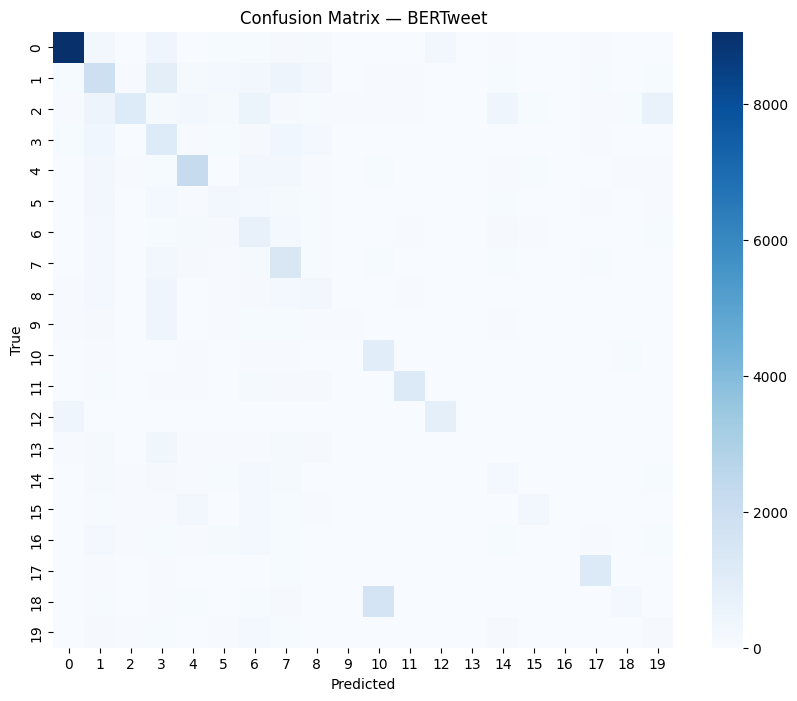


❌ Sample of wrong predictions (BERTweet):


,text,true_label,pred_label
49255,30% OFF BSICK Yoga Outfits!! #summer17 #blowou...,4,7
37251,There's NO place like HOME • Get your copy to...,15,7
33438,Hey Everybody! I have not spammed you - all th...,19,14
37411,Get home and there’s mail from my old car insu...,16,5
30647,Authentic Athletic Wear. .......#fitness #fit ...,15,4
7107,": @user @ Brunswick, Ohio",18,10
48409,@user in LA _____#sashasherman #la #ralphs #хл...,11,10
43491,My Duff Duff is all ready for Christmas after ...,16,0
13966,"Always @ New York, New York",1,3
8649,"Best friends forever Love you babe, thank you ...",0,3


In [ ]:
# ============================================
#  PART 4 — Complete Evaluation + Analysis (Stable for CPU/GPU)
# ============================================
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from torch.utils.data import DataLoader, TensorDataset

# ----------------------------------------------------
#  Automatically detect device (GPU if available, else CPU)
# ----------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"✅ Using device: {device}")

# ----------------------------------------------------
#  Already trained models and tokenizers (from memory)
# ----------------------------------------------------
models_in_memory = {
    "DistilBERT": trainer_distilbert,
    "DistilRoBERTa": trainer_distilroberta,
    "BERTweet": trainer_bertweet
}

tokenizers = {
    "DistilBERT":  tokenizer_distilbert,
    "DistilRoBERTa":  tokenizer_distilroberta,
    "BERTweet":  tokenizer_bertweet
}

# ----------------------------------------------------
#  Load the test dataset
# ----------------------------------------------------
test_texts = test["text"].tolist()
test_labels = test["label"].astype(int).tolist()

# ----------------------------------------------------
#  Universal evaluation function (robust and portable)
# ----------------------------------------------------
def evaluate_model(model_name, trainer):
    print(f"\n🚀 Evaluating model: {model_name}")

    try:
        model = trainer.model.to(device)
        tokenizer = tokenizers[model_name]

        # Tokenize test data
        encoded = tokenizer(
            test_texts,
            padding=True,
            truncation=True,
            return_tensors="pt",
            max_length=75
        )

        test_dataset = TensorDataset(
            encoded["input_ids"],
            encoded["attention_mask"],
            torch.tensor(test_labels)
        )
        test_loader = DataLoader(test_dataset, batch_size=16)

        all_preds, all_labels = [], []

        # Try running on GPU first, fallback to CPU if error occurs
        try:
            model.eval()
            with torch.no_grad():
                for batch in test_loader:
                    input_ids = batch[0].to(device)
                    attention_mask = batch[1].to(device)
                    labels = batch[2].to(device)

                    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                    logits = outputs.logits if hasattr(outputs, "logits") else outputs
                    preds = torch.argmax(logits, dim=1)

                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

        except Exception as e_gpu:
            print(f"⚠️ GPU error detected ({e_gpu}), switching to CPU...")
            cpu_device = torch.device("cpu")
            model.to(cpu_device)
            with torch.no_grad():
                for batch in test_loader:
                    input_ids = batch[0].to(cpu_device)
                    attention_mask = batch[1].to(cpu_device)
                    labels = batch[2].to(cpu_device)

                    outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                    logits = outputs.logits if hasattr(outputs, "logits") else outputs
                    preds = torch.argmax(logits, dim=1)

                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

        # Compute metrics
        acc = accuracy_score(all_labels, all_preds)
        f1_macro = f1_score(all_labels, all_preds, average="macro")
        f1_weighted = f1_score(all_labels, all_preds, average="weighted")

        print(f"✅ {model_name} — Accuracy: {acc:.4f}, Macro F1: {f1_macro:.4f}")

        return {
            "Model": model_name,
            "Accuracy": acc,
            "Macro F1": f1_macro,
            "Weighted F1": f1_weighted,
            "y_true": np.array(all_labels),
            "y_pred": np.array(all_preds)
        }

    except Exception as e:
        print(f"❌ Error during evaluation of {model_name}: {e}")
        return {"Model": model_name, "Accuracy": None, "Macro F1": None, "Weighted F1": None, "y_true": [], "y_pred": []}


# ----------------------------------------------------
#  Evaluate all models
# ----------------------------------------------------
results = [evaluate_model(name, trainer) for name, trainer in models_in_memory.items()]

# ----------------------------------------------------
#  Create a summary comparison table
# ----------------------------------------------------
df_results = pd.DataFrame(results)[["Model", "Accuracy", "Macro F1", "Weighted F1"]]
df_results = df_results.sort_values("Macro F1", ascending=False)
print("\n📊 Model performance comparison:")
display(df_results)

# ----------------------------------------------------
#  Confusion matrix for the best-performing model
# ----------------------------------------------------
best_model_name = df_results.iloc[0]["Model"]
best_entry = [r for r in results if r["Model"] == best_model_name][0]

y_true, y_pred = best_entry["y_true"], best_entry["y_pred"]

if len(y_true) > 0:
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, cmap="Blues", annot=False)
    plt.title(f"Confusion Matrix — {best_model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

# ----------------------------------------------------
#  Error analysis
# ----------------------------------------------------
if len(y_true) > 0:
    df_errors = pd.DataFrame({
        "text": test["text"],
        "true_label": y_true,
        "pred_label": y_pred
    })
    df_errors = df_errors[df_errors["true_label"] != df_errors["pred_label"]]
    print(f"\n❌ Sample of wrong predictions ({best_model_name}):")
    display(df_errors.sample(min(10, len(df_errors)), random_state=42))
else:
    print("⚠️ No valid test data available for error analysis.")



# Analyze the results
BERTweet: Accuracy = 0.471, Macro-F1 = 0.343, Weighted-F1 = 0.464
DistilRoBERTa: Accuracy = 0.433, Macro-F1 = 0.303, Weighted-F1 = 0.425
DistilBERT: Accuracy = 0.336, Macro-F1 = 0.213, Weighted-F1 = 0.280

BERTweet performs best on both accuracy and Macro-F1, indicating better robustness across classes


Confusion matrix (best model: BERTweet)

The confusion matrix is mostly diagonal with several notable off-diagonal blocks:
A strong diagonal for the most frequent class (label 0), suggesting the model is confident and accurate where it has ample data.
Systematic confusions across semantically similar emojis, e.g., “joy/laughter”-like labels or “positive-affect” emojis tend to be mixed. This is expected because many tweets are short and context-light, and multiple emojis can be plausible for the same sentence.
Sparse but persistent confusion among low-resource classes (bottom rows/columns), consistent with the imbalance observed in EDA.


Error analysis (samples & patterns)

From misclassified examples, several recurring themes appear:
Promotional/templated content with many hashtags (e.g., fitness, sales) and minimal sentiment cues. The model often defaults to generic positive/neutral emojis.
Tweets dominated by metadata (user mentions, locations like “@ New York, New York”, handles, @user) with little semantic content; prediction becomes guessy.
Ambiguity & multi-emoji plausibility: many tweets could reasonably map to multiple emojis; the ground truth is one label, but several are “close enough,” leading to confusions rather than outright errors.
Domain noise (brand names, promo codes, multi-language/romanization, emojis missing in text): the model relies on weak sentiment cues, so it leans toward frequent classes.
These patterns explain why Macro-F1 lags: rare/nuanced classes lack clear textual signals and sufficient examples.

# Gradio Demo

In [28]:
#!ls runs/emoji_BERTweet/best


added_tokens.json  config.json		    tokenizer_config.json
best_meta.json	   model.safetensors	    training_args.bin
bpe.codes	   special_tokens_map.json  vocab.txt


In [29]:
!pip install gradio -q


In [30]:
id2emoji = {
    0:"❤",1:"😍",2:"😂",3:"💕",4:"🔥",
    5:"😊",6:"😎",7:"✨",8:"💙",9:"😘",
    10:"📷",11:"🇺🇸",12:"☀",13:"💜",14:"😉",
    15:"💯",16:"😁",17:"🎄",18:"📸",19:"😜"
}


In [31]:
!pip install emoji==0.6.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.0/51.0 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-0.6.0-py3-none-any.whl size=49719 sha256=f1504a5257fffd5b17699b8baee8be67d7673fc53e2f5d0d125faafe95bcc0e1
  Stored in directory: /root/.cache/pip/wheels/0d/bf/a2/536017b4a6232aef0fb92831af35facd6590c0af0f3983f63b
Successfully built emoji


In [32]:
from transformers import pipeline

model_path = "runs/emoji_BERTweet/best"
clf = pipeline("text-classification", model=model_path, tokenizer=model_path, return_all_scores=True)


Device set to use cuda:0
/usr/local/lib/python3.12/dist-packages/transformers/pipelines/text_classification.py:111: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


In [51]:
import gradio as gr

# Function to predict emojis with a visually appealing HTML output
def predict_emoji_visual(text):
    if not text.strip():
        return "<p style='color:red; font-weight:bold;'>Please enter some text.</p>"

    # Get predictions from classifier
    preds = clf(text)[0]

    # Sort by score and take top 3
    top3 = sorted(preds, key=lambda x: x['score'], reverse=True)[:3]

    # Normalize scores to sum to 100%
    total_score = sum(p['score'] for p in top3)

    # Build HTML table
    html_output = "<table style='font-size:24px; text-align:center; margin:auto;'>"
    html_output += "<tr><th>Emoji</th><th>Probability</th></tr>"

    for p in top3:
        label_idx = int(p['label'].split('_')[-1])
        emoji = id2emoji.get(label_idx, "❓")
        percent = round((p['score']/total_score) * 100, 1)
        html_output += f"<tr><td>{emoji}</td><td>{percent}%</td></tr>"

    html_output += "</table>"
    return html_output


# Create Gradio interface with HTML output
demo = gr.Interface(
    fn=predict_emoji_visual,
    inputs=gr.Textbox(lines=3, label="Enter a tweet or short text here..."),
    outputs=gr.HTML(label="Top 3 Emoji Predictions"),  # HTML output for visual table
    title="Tweet Emoji Predictor 🤖✨",
    description=(
        "Unlock the sentiment! This app uses a fine-tuned BERTweet model to predict the **top 3 most likely emojis** for your text. "
        "Just type or paste your tweet below and hit submit! The percentages shown for the top 3 sum to 100%."
    ),
    examples=[
        ["Feeling absolutely ecstatic about this project!"],
        ["That movie was so funny, I was in tears "],
        ["Missing the beach and sunshine right now"],
        ["Work meeting could have gone better..."],
        ["Just finished a great workout "]
    ],
    theme="soft"
)

demo.launch(share=True)


* Running on local URL:  http://127.0.0.1:7860
* Running on public URL: https://c2988c6685d6206fb9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
#!pip freeze > requirements.txt


In [ ]:
#from google.colab import files
#files.download('requirements.txt')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>